# Warm up example

This notebook is intended to walk through some of the basics of NeuralVerification.jl and to serve as a quick-start example

In [1]:
using NeuralVerification, LazySets

### NNET files

First thing is first: to verify a network, we need to *have* a network. We can read a network from a .nnet file using the `read_nnet` function. 

In this notebook we will look at the file "small_nnet_id.nnet", which has two hidden layers with two nodes each. Let's first read the file as text to see what it looks like.

In [2]:
println(read("models/small_nnet_id.nnet", String))

3
1, 2, 2, 1
0
0
0
0
0
1
1
1.5
1.5
2, 2
2, 2
2.5
2.5
-3, -3
3.5



Above we see the exact contents of the .nnet file at text. The first line is how many layers are in the network (2 hidden plus the input makes 3). The next line tells the input size of each layer, as well as the output size of the network (1). The following rows with zeros do nothing usually and are skipped in parsing. After that are listed the weights and biases of each layer.

We can parse this text file into a `Network` object using `read_nnet`. It is also possible to create Networks by putting together a series of `Layer`s manually. For an example of that, see the [visualverification](visualverification.ipynb) notebook.

In [3]:
net = read_nnet("models/small_nnet_id.nnet")

net.layers

3-element Array{NeuralVerification.Layer,1}:
 NeuralVerification.Layer{NeuralVerification.ReLU,Float64}([1.0; 1.0], [1.5, 1.5], NeuralVerification.ReLU())        
 NeuralVerification.Layer{NeuralVerification.ReLU,Float64}([2.0 2.0; 2.0 2.0], [2.5, 2.5], NeuralVerification.ReLU())
 NeuralVerification.Layer{NeuralVerification.Id,Float64}([-3.0 -3.0], [3.5], NeuralVerification.Id())                

Note in the list of layers above that each layer has an activation function associated with it. The first two have `NeuralVerification.ReLU()` as their activation and the last one has `NeuralVerification.Id()` (identity). It is an assumption of the .nnet format that all layers except the output are ReLU layers. In order to create layers with different activation types, it is necessary at the moment to do so manually with the `Layer` constructor.

Now that we have a network, and that network is conveniently a 1D to 1D mapping, let's see what it encodes:

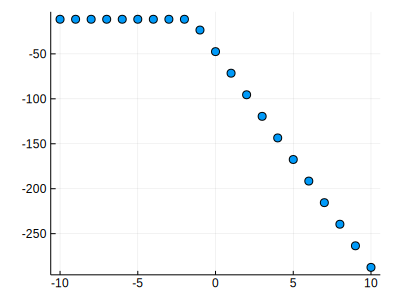

In [22]:
using Plots; default(size = (400,300), legend = :none)

# compute_output(net, x) performs net(x)
import NeuralVerification.compute_output 

domain = -10:10
y = [compute_output(net, x)[1] for x in domain]
scatter(domain, y)

### Input/Output Sets, `Problem`s, and `Result`s

Obviously this network is very simple, and verification of any property of it can be done simply with pencil and paper, but we will carry on with the example!

Suppose from the scatterplot above we guess that all outputs in the domain $X = [-10, 10]$ lie between $Y = [-20, -270]$. We can encode that property and attempt to falsify it using a wide range of algorithms. We can declare the two sets of interest and construct a `Problem` instance. Then we can use any algorithm in the library (that supports Hyperrectangles in this case) to test the property.

In [5]:
X = Hyperrectangle(low = [-10.0], high = [10.0])
Y = Hyperrectangle(low = [-270.0], high = [-20.0])

prob = Problem(net, X, Y)

res = solve(ExactReach(), prob)

ReachabilityResult(:violated, HPolytope[HPolytope{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([1.0], -11.5), HalfSpace{Float64}([-1.0], 11.5)]), HPolytope{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([1.0], -11.5), HalfSpace{Float64}([-1.0], 11.5)]), HPolytope{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([1.0], -11.5), HalfSpace{Float64}([-1.0], 11.5)]), HPolytope{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([1.0], -11.5), HalfSpace{Float64}([-1.0], 287.5)])])

Using ExactReach, we get a `ReachabilityResult` indicating that the property is violated. When this happens, we also get the computed reachable set to inspect. In the printout of the subsets below, we see that each `HPolytope` consists of two `HalfSpaces` that differ by a minus sign. In fact, that constraint each of those `HPolytope`s to a single point. The final `HPolytope` is the only exception, and it is an interval. 

Since our guess was wrong, we should probably look at the reachable set. We can use the `LazySets` function `vertices_list` to get some 1D y-values to plot with and visualize the interval. The plotting in this problem is merely for demonstration; most neural networks don't necessarily have a visual interpretation. In [another example](visualverification.ipynb), we look at sets that are more interesting than intervals.

In [6]:
res.status

:violated

In [7]:
res.reachable

4-element Array{HPolytope,1}:
 HPolytope{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([1.0], -11.5), HalfSpace{Float64}([-1.0], 11.5)]) 
 HPolytope{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([1.0], -11.5), HalfSpace{Float64}([-1.0], 11.5)]) 
 HPolytope{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([1.0], -11.5), HalfSpace{Float64}([-1.0], 11.5)]) 
 HPolytope{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([1.0], -11.5), HalfSpace{Float64}([-1.0], 287.5)])

In [8]:
verts = vertices_list.(res.reachable)

4-element Array{Array{Array{Float64,1},1},1}:
 [[-11.5]]          
 [[-11.5]]          
 [[-11.5]]          
 [[-11.5], [-287.5]]

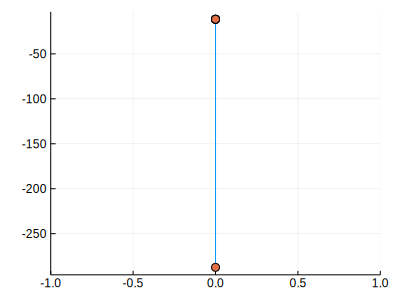

In [9]:
verts = reduce(vcat, reduce(vcat, verts)) # reduce an array of arrays of arrays into just an array.

# embed the vertices into two dimensions (setting x₁ = 0) so we can plot the interval
verts2d = collect(zip(zeros(length(verts)), verts))

plot(verts2d, seriestype = [:line, :scatter], xlim = (-1, 1))

Cool.

### More Solvers

We've seen reachability analysis, but let's now try an algorithm that uses a different approach. Optimization based methods encode the relations in the network as an optimization problem (often convexifying the activation function in some fashion).

In most of these algorithms, the output set relation is "negated" in then encoding, such that what is ultimately encoded is the complement of the provided set. Essentially, rather than checking if the output is in $Y$ the optimization/feasibility problem checks if the output is not-in-$Y_c$. For these algorithms, $Y$ must be the complement of a convex set so that the resulting optimization problem is convex. We provide the `PolytopeComplement` type and the `complement` function to construct such sets. 

Below, we declare the set $Y_c$, the complement of the desired output set, to be the set $Y_c = \{y \mid y \geq -12\}$. $Y$, the complement of $Y_c$, is therefore $Y = \{y \mid y \leq -12\}$. We then use `NSVerify`, an optimization-based solver, to check if this property holds (it does not, clearly).

In [10]:
Yc = HPolytope(reshape([-1.0], 1, 1), [12.0])
Y = complement(Yc)

PolytopeComplement of:
  HPolytope{Float64}(HalfSpace{Float64}[HalfSpace{Float64}([-1.0], 12.0)])


In [11]:
prob = Problem(net, X, Y)
res = solve(NSVerify(), prob)

CounterExampleResult(:violated, [-1.5])

Optimization methods do not return `ReachabilityResult`s. Instead, `NSVerify` returned a `CounterExampleResult`, again indicating that the property is violated and returning a counter-example. Calling up the documentation for `CounterExampleResult` with `?`, we can see the second field is called `counter_example`.

In [12]:
?CounterExampleResult

search: CounterExampleResult



```
CounterExampleResult(status, counter_example)
```

Like `BasicResult`, but also returns a `counter_example` if one is found (if status = :violated). The `counter_example` is a point in the input set that, after the NN, lies outside the output set.


In [13]:
compute_output(net, res.counter_example)

1-element Array{Float64,1}:
 -11.5

Plugging in our new counter-example, we find that indeed, $f(x) = -11.5 \geq -12$, so the property is truly violated. This is worth noting, since algorithms which are not complete may sometimes return an acceptable point is a counter-example due to their convexification of the network encoding.

### :holds

So far we have only looked at violated properties. For the sake of completeness, if we encode a property we know holds, such as $Y = \{y \mid y \leq -10 \}$ and again solve the property with `NSVerify`, we see that it holds.

In [14]:
Yc = HPolytope(reshape([-1.0], 1, 1), [10.0])
Y = complement(Yc)
prob = Problem(net, X, Y)
res = solve(NSVerify(), prob)

CounterExampleResult(:holds, Float64[])

Two other types of `Result`s are possible, `BasicResult`, which only states `:holds` or `:violated`, and `AdversarialResult` which gives a perturbation radius in the input domain.

In [15]:
X = Hyperrectangle(low = [-10.0], high = [10.0])
Y = Hyperrectangle(low = [-270.0], high = [-20.0]);
prob = Problem(net, X, Y)

res = solve(FastLin(), prob)

AdversarialResult(:violated, 1.09375)

### Docs

We can pull up the documentation for any function in `NeuralVerification.jl` interactively such as here, or in the [online documentation](https://sisl.github.io/NeuralVerification.jl/latest/) to read about our implementation of each algorithm, determine appropriate input/output types, or find references to the original papers describing each method.

In [16]:
methods(NeuralVerification.solve)

# 18 methods for generic function "solve":
[1] solve(m::JuMP.Model; kwargs...) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/NeuralVerification.jl:57
[2] solve(solver::NSVerify, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/optimization/nsVerify.jl:32
[3] solve(solver::ConvDual, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/optimization/convDual.jl:29
[4] solve(solver::Duality, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/optimization/duality.jl:34
[5] solve(solver::Certify, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/optimization/certify.jl:34
[6] solve(solver::ILP, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/optimization/iLP.jl:36
[7] solve(solver::MIPVerify, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/optimization/mipVerify.jl:34
[8] solve(solver::ExactReach, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/reachability/exactReach.jl:28
[9] solve(solver::MaxSens, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/reachability/maxSens.jl:35
[10] solve(solver::Ai2, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/reachability/ai2.jl:28
[11] solve(solver::BaB, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/satisfiability/bab.jl:35
[12] solve(solver::Planet, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/satisfiability/planet.jl:34
[13] solve(solver::Sherlock, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/satisfiability/sherlock.jl:36
[14] solve(solver::Reluplex, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/satisfiability/reluplex.jl:30
[15] solve(solver::ReluVal, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/adversarial/reluVal.jl:50
[16] solve(solver::FastLin, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/adversarial/fastLin.jl:37
[17] solve(solver::FastLip, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/adversarial/fastLip.jl:38
[18] solve(solver::DLV, problem::Problem) in NeuralVerification at /Users/tomer/.julia/dev/NeuralVerification/src/adversarial/dlv.jl:43

In [17]:
?BaB

search: BaB AbstractBackend backend_object AbstractRGB bytesavailable



```
BaB(optimizer, ϵ::Float64)
```

BaB uses branch and bound to estimate the range of the output node.

# Problem requirement

1. Network: any depth, ReLU activation, single output
2. Input: hyperrectangle
3. Output: hyperrectangle (1d interval)

# Return

`CounterExampleResult` or `ReachabilityResult`

# Method

Branch and bound. For branch, it uses iterative interval refinement. For bound, it computes concrete bounds by sampling, approximated bound by optimization.

  * `optimizer` default `GLPKSolverMIP()`
  * `ϵ` is the desired accurancy for termination, default `0.1`.

# Property

Sound and complete.

# Reference

[R. Bunel, I. Turkaslan, P. H. Torr, P. Kohli, and M. P. Kumar, "A Unified View of Piecewise Linear Neural Network Verification," *ArXiv Preprint ArXiv:1711.00455*, 2017.](https://arxiv.org/abs/1711.00455)
